<a href="https://colab.research.google.com/github/Bileth/Grayscale-image-colorization/blob/master/CNN_colorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

In [53]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D as Conv2D, MaxPooling2D
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras import backend as K
from keras import losses
from tensorflow.keras.layers import BatchNormalization

In [54]:
def read_images(path,num_images,xdim,ydim):
    images = []
    all_paths = os.listdir(path)
    mini_set = all_paths[:num_images]
    for i in mini_set:
        file = path+"/"+i
        image = cv2.imread(file)
        image = cv2.resize(image,(xdim,ydim))
        images.append(image)

    return images

#funkcija za pretvaranje rgb u  lab 
def rgb_to_lab(images):
    lab_images = []
    for i in images:
        lab_image= cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
        lab_images.append(lab_image)

    return lab_images

def lab_to_rgb(images):
    rgb_images = []
    for i in images:
        lab_image= cv2.cvtColor(i, cv2.COLOR_LAB2RGB)
        lab_images.append(lab_image)

#funkcija za izdvajanje l kanala i ab za trening 
def extract_channels(lab_images):
    l_channels = []
    a_channels = []
    b_channels = []
    for i in lab_images:
        l,a,b = cv2.split(i)
        l_channels.append(l)
        a_channels.append(a)
        b_channels.append(b)

    return np.array(l_channels), np.array(a_channels), np.array(b_channels)

#funkcija za stvaranje podataka za treniranje i testiranje
def create_train_data(l,a,b):
    train_data = []
    for i in l:
        train_data.append(np.array(i,dtype= 'float32'))
    train_labels_a = []
    train_labels_b = []
    for i in a:
        train_labels_a.append(np.array(i.flatten(),dtype='float32'))
    for i in b:
        train_labels_b.append(np.array(i.flatten(),dtype='float32'))
    train_labels = []
    for i,j in zip(train_labels_a,train_labels_b):
        train_labels.append(np.concatenate((i,j),axis = 0))
    
    return train_data, train_labels

In [4]:
!rm -rf clone && git clone https://github.com/Bileth/Grayscale-image-colorization clone && cp -a clone/. .

Cloning into 'clone'...
remote: Enumerating objects: 14336, done.
remote: Counting objects: 100% (14336/14336), done.
remote: Compressing objects: 100% (14328/14328), done.
remote: Total 14336 (delta 7), reused 14320 (delta 2), pack-reused 0
Receiving objects: 100% (14336/14336), 346.46 MiB | 28.03 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (22301/22301), done.


In [55]:
path = "train/images/color"  
num_images = 7000  
x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim)
lab_images = rgb_to_lab(images)
l,a,b = extract_channels(lab_images)
train_data, train_labels = create_train_data(l,a,b)

In [56]:
train_data = np.reshape(train_data,(num_images,x_dim,y_dim,1))
train_data.shape[3]
train_labels = np.reshape(train_labels,(num_images,128*128*2))

In [60]:
img_cols = 128
img_rows = 128
if K.image_data_format() == 'channels_first':
    train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(16, (5, 5),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (4, 4),activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(train_labels.shape[1], activation='linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 124, 124, 16)      416       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 59, 59, 16)        4112      
                                                                 
 batch_normalization_12 (Bat  (None, 59, 59, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 29, 29, 16)       0         
 g2D)                                                            
                                                      

In [61]:
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [62]:
batch_size = 50
epochs = 300
model.fit(train_data, train_labels,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/300
140/140 [==============================] - 16s 100ms/step - loss: 3485.5459 - accuracy: 2.8571e-04
Epoch 2/300
140/140 [==============================] - 14s 100ms/step - loss: 372.2998 - accuracy: 2.8571e-04
Epoch 3/300
140/140 [==============================] - 14s 100ms/step - loss: 312.9671 - accuracy: 1.4286e-04
Epoch 4/300
140/140 [==============================] - 14s 100ms/step - loss: 275.2627 - accuracy: 2.8571e-04
Epoch 5/300
140/140 [==============================] - 14s 99ms/step - loss: 264.8599 - accuracy: 0.0000e+00
Epoch 6/300
140/140 [==============================] - 14s 100ms/step - loss: 246.2814 - accuracy: 0.0000e+00
Epoch 7/300
140/140 [==============================] - 14s 99ms/step - loss: 244.6030 - accuracy: 1.4286e-04
Epoch 8/300
140/140 [==============================] - 14s 100ms/step - loss: 240.2934 - accuracy: 4.2857e-04
Epoch 9/300
140/140 [==============================] - 14s 100ms/step - loss: 238.1615 - accuracy: 1.4286e-04
Epoch 10/30

In [63]:
model.save("CNN_colorize.h5")

In [64]:
path = "test/images/gray"
num_images = 19

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
train_data, train_labels = create_train_data(l,a,b)

In [85]:
index = 0 #odabir slike
tr = np.reshape(train_data[index],(1,128,128,1)) 
p = model.predict(tr) 

In [86]:
x = list(p[0])
length = len(p[0])
x1 = x[:int(length/2)] #podjela predviđenog a i b kanala u jednake polovice kako bi ih dobili
x2 = x[int(length/2):]

x1 = np.array(np.reshape(x1,(x_dim,y_dim)),dtype = 'uint8')
x2 = np.array(np.reshape(x2,(x_dim,y_dim)),dtype = 'uint8')

t = np.array(np.reshape(tr,(x_dim,y_dim)),dtype = 'uint8')
pred = cv2.merge((t,x1,x2)) #spajanje L kanala sa a i b kanalima kako bi dobili obojanu sliku

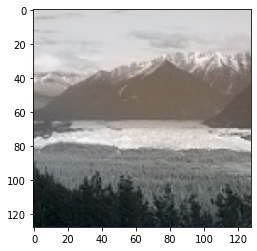

In [87]:
pred_n = cv2.cvtColor(pred, cv2.COLOR_LAB2RGB);
plt.imshow(pred_n)